In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

gts_final = gts = pd.read_csv("../train/train_gts_final.csv")
meta = pd.read_csv("../train/train_meta.csv")

df = meta.merge(gts_final, on='record_name')

In [3]:
def print_record(x, y, name):
    plt.figure(figsize=(16, 8))

    plt.plot(x, y)
    plt.title(name)
    plt.xlabel("Time")
def _load_record(prefix, record_name):
    path = os.path.join(prefix, record_name + ".npy")
    record = np.load(path)
    return record

def norm(record):
    # Normalisation: follow PTB-XL demo code. Do zero mean, unit var normalisation across all leads, timesteps, and patients
    meansig = np.mean(record.reshape(-1))
    stdsig = np.std(record.reshape(-1))
    res = (record- meansig)/stdsig
    return res 


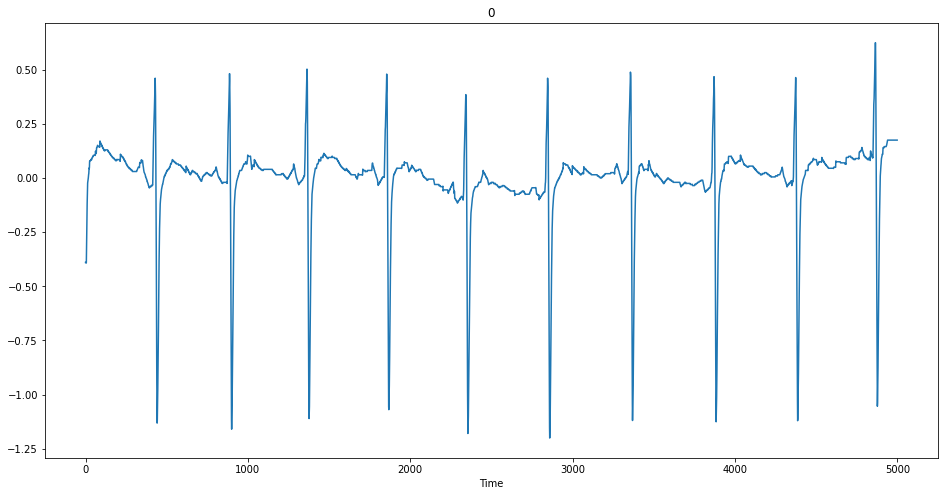

In [4]:

record = _load_record("./../train/", '00009_hr')
print_record([x for x in range(len(record[6]))], record[6], 0)

В той репе делали нормализацию всего датасета а я один сэмпл хз

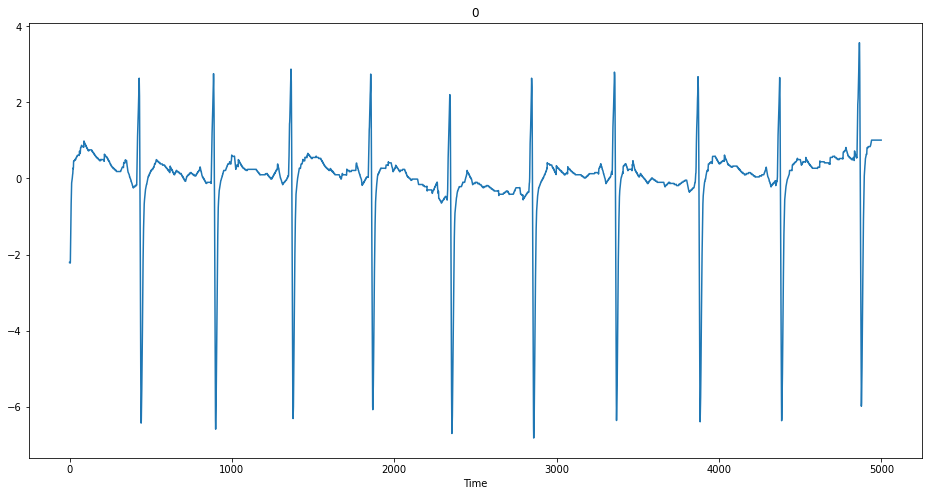

In [5]:
record_norm = norm(record)
print_record([x for x in range(len(record_norm[6]))], record_norm[6], 0)

Baseline wander

torch.Size([1, 12, 5000])
res shape torch.Size([1, 12, 5000])


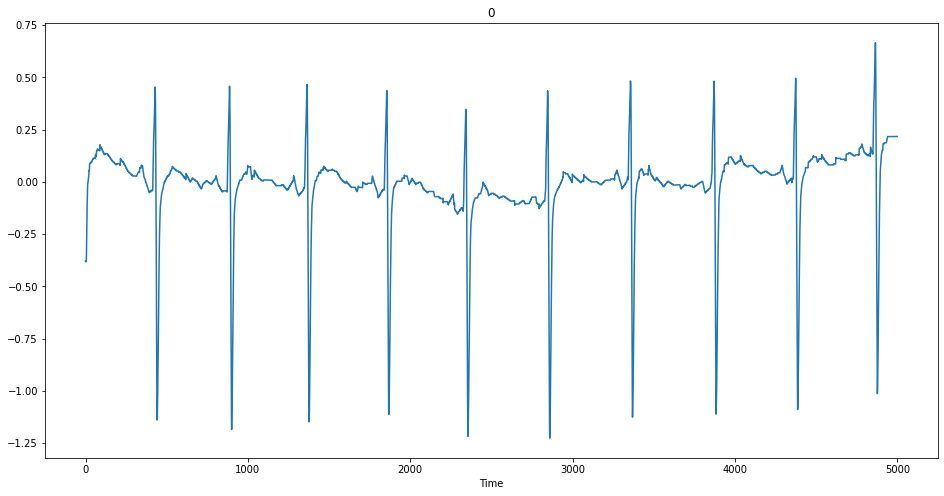

In [6]:
from functional import baseline_wander, gaussian_noise, spec_aug, rand_displacement, rand_temporal_warp,magnitude_scale,rand_crop
EPS = 1 # надо поиграться
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
res = baseline_wander(inp, torch.Tensor([EPS]))
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

torch.Size([1, 12, 5000])
res shape torch.Size([1, 12, 5000])


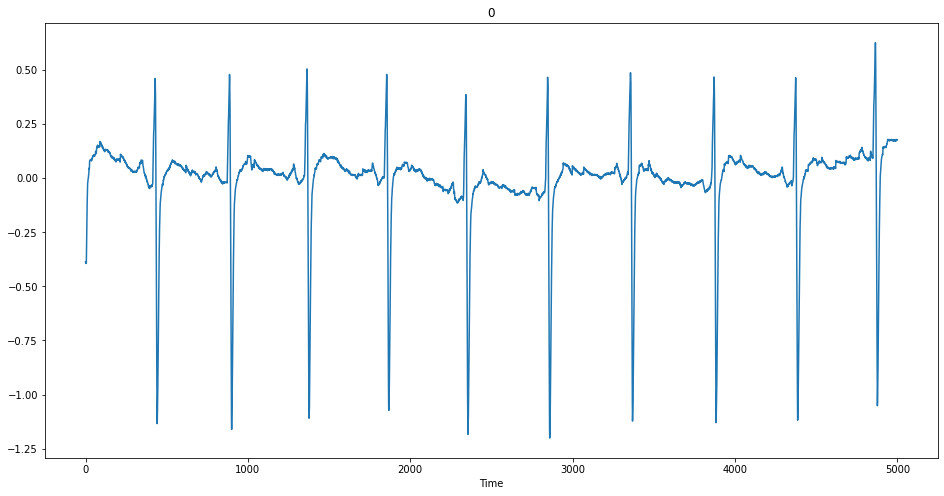

In [7]:
EPS = -3 # [-3;-2] - норм остальное слишком сильно
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
res = gaussian_noise(inp, torch.Tensor([EPS]))
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

Spec aug хз что это вроде ничего не меняется

torch.Size([1, 12, 5000])
res shape torch.Size([1, 12, 5000])


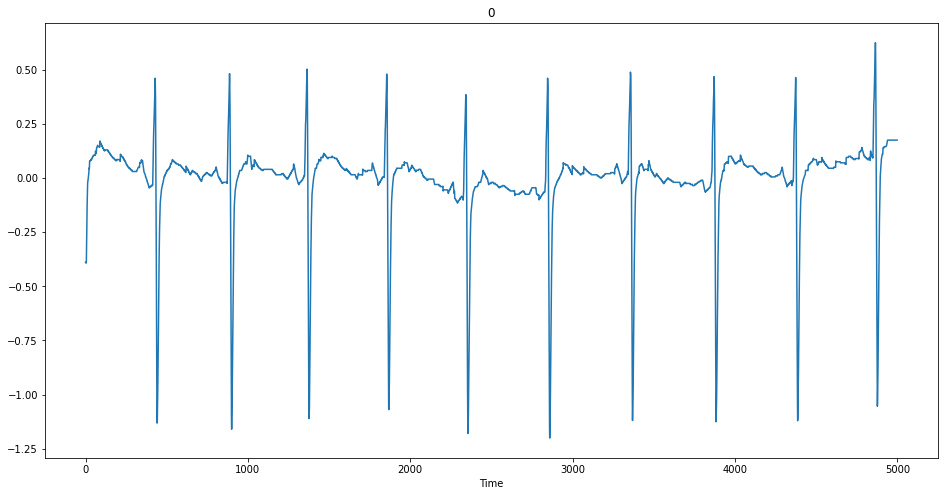

In [8]:
EPS = -1000
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
res = spec_aug(inp, torch.Tensor([EPS]))
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

Magnitude scale Меняет максимальные минимальные значения вроде или просто вдоль y растягивает 

torch.Size([1, 12, 5000])
res shape torch.Size([1, 12, 5000])


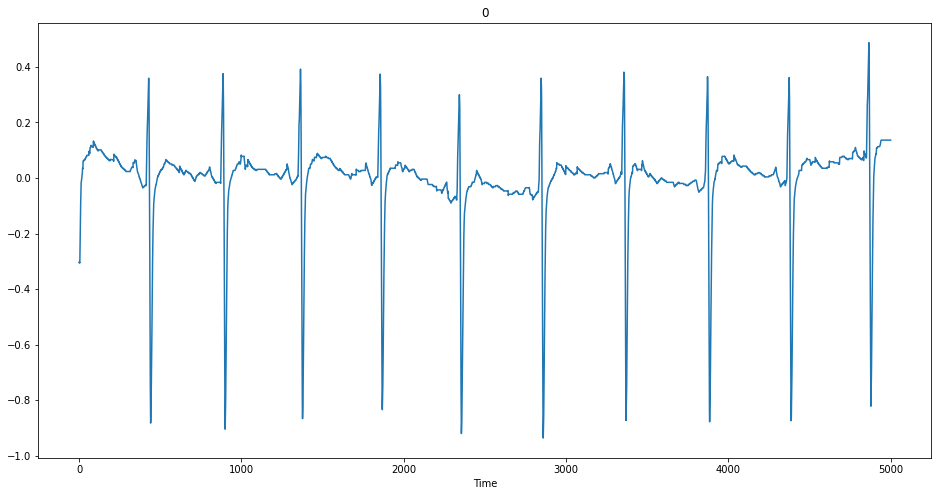

In [9]:
EPS = 1
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
res = magnitude_scale(inp, torch.Tensor([EPS]))
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

Random crop зануляет какой то участок, mag = от 0 до 1

torch.Size([1, 12, 5000])
res shape torch.Size([1, 12, 5000])


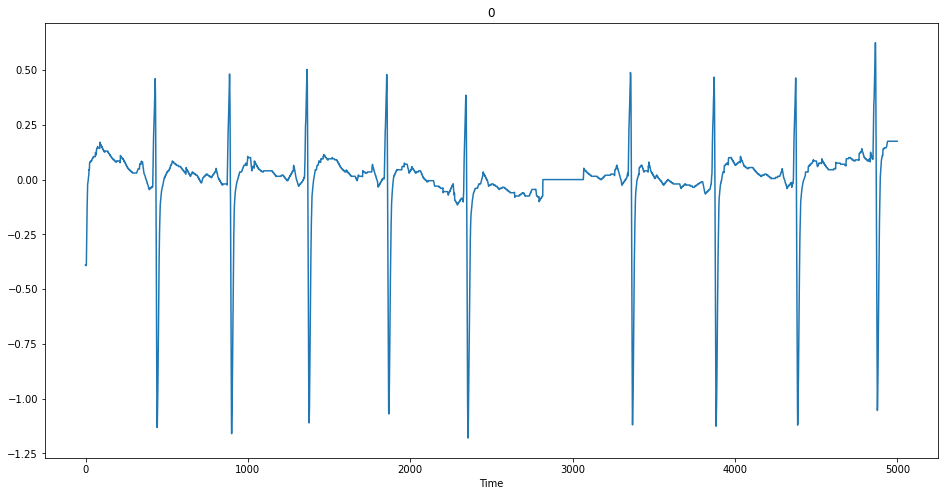

In [10]:
EPS = 0.05
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
res = rand_crop(inp, torch.Tensor([EPS]))
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

In [11]:
EPS = 0
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)
print(inp.shape)
# TODO разобраться что такое warp obj
res = rand_displacement(inp, torch.Tensor([EPS]), )
print('res shape', res.shape)
record_new = res.squeeze()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

torch.Size([1, 12, 5000])


TypeError: rand_displacement() missing 1 required positional argument: 'warp_obj'

Aug Policy, с гаусиан шумом слишком шумные выходят 

res shape torch.Size([1, 12, 5000])


/mnt/D/conda/envs/open-mmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


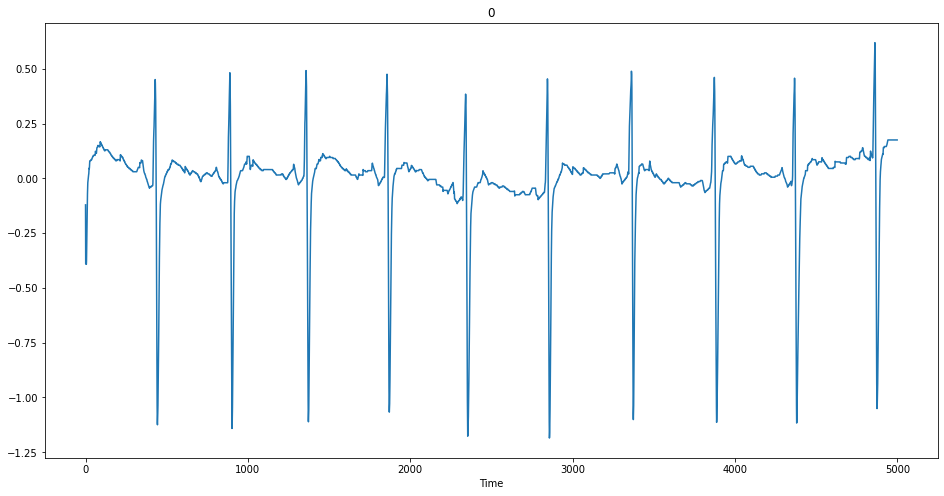

In [12]:
from aug_policy import full_policy, RandTemporalWarp, RandDisplacement
policy = full_policy() # все аугментации, выбирается по рандому
label = torch.Tensor([0])
inp = torch.Tensor(record)
inp = inp.unsqueeze(dim=0)

res = policy(inp, torch.Tensor([0])) # takes x, y as arguments, let 0 be norm
print('res shape', res.shape)
record_new = res.squeeze().detach().numpy()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)

Не могу понять что делает

res shape torch.Size([1, 12, 5000])


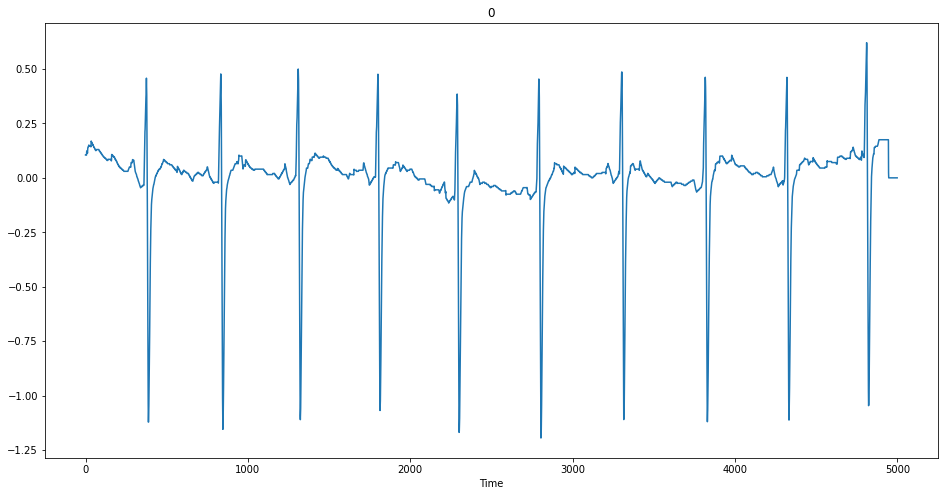

In [13]:
policy2 = RandDisplacement(temperature=1, initial_magnitude=[-1, -1])
res = policy2(inp, torch.Tensor([0])) # takes x, y as arguments, let 0 be norm
print('res shape', res.shape)
record_new = res.squeeze().detach().numpy()
print_record([x for x in range(len(record_new[6]))], record_new[6], 0)